In [74]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import holidays
pd.options.display.max_rows = 50
import json
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format

In [75]:
from scipy.optimize import minimize

In [118]:
def DailyModel_base(daily_data):
    '''Calls all daily models, returns dictionary'''
    estimated_daily = {}
    estimated_daily['Daily'] = Model1_base(daily_data)
    return Model1_base(daily_data)

def arma_ale_base(daily_data):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data_base(daily_data)
    train, test = split_dataset_base(modified_data, 0.7)
    y_true = train['y_true'].values
    res = minimize(my_objective_base, np.array([0.5, 0.5], dtype=float), args=train['y_true'].values)
    phi, theta = res.x
    test['y_hat'] = estimate_y_base(test['y_true'].values, phi, theta,0.7)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi, theta

def Model1_base(daily_data):
    output = arma_ale_base(daily_data)
    return output[0]['log_total_vol_hat'], output[1], output[2]

def prep_data_base(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM'].shift()
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    data.set_index('DATE', inplace=True)

    return data

def split_dataset_base(dataset, split_level):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y_base(train['y_true'].values, 0.7, -0.3, False)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y_base(y_true, phi, theta, predict):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
        eps[t] = y_true[t] - y_hat[t]

    if predict:
        predict_y = phi * y_true[-1] + theta * eps[-1]
        return predict_y
    else:
        return y_hat

def my_objective_base(param, y_true):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi = param[0]
    theta = param[1]
    y_hat = estimate_y_base(y_true, phi, theta,0.7)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v

In [217]:
def DailyModel(daily_data):
    '''Calls all daily models, returns dictionary'''
    estimated_daily = {}
    estimated_daily['Daily'] = Model1(daily_data)
    return Model1(daily_data)

def piecewise_phi(x, phi1,phi2):
    if (abs(x) < 0.01):
        return phi1
    else:
        return phi1 - phi2 * abs(abs(x) - 0.01)

def arma_ale(daily_data):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data(daily_data)
    train, test = split_dataset(modified_data, 0.7)
    y_true = train['y_true'].values
    res = minimize(my_objective, np.array([1,0.2,-0.5], dtype=float), args=train['y_true'].values)
    phi1, phi2, theta = res.x
    test['y_hat'] = estimate_y(test['y_true'].values, phi1, phi2,  theta,0.7)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi1, phi2, theta

def Model1(daily_data):
    output = arma_ale(daily_data)
    return output[0]['log_total_vol_hat'], output[1], output[2], output[3]

def prep_data(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM'].shift()
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    data.set_index('DATE', inplace=True)

    return data

def split_dataset(dataset, split_level):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y(train['y_true'].values, 0.7, 0.3,-0.3, False)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y(y_true,phi1, phi2,theta, predict):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = piecewise_phi(y_true[t - 1],phi1,phi2)  + theta*(eps[t - 1])
        eps[t] = y_true[t] - y_hat[t]

    if predict:
        predict_y = piecewise_phi(y_true[t - 1],phi1,phi2)  + theta*(eps[t - 1])
        return predict_y
    else:
        return y_hat

def my_objective(param, y_true):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi1 = param[0]
    phi2 = param[1]
    theta = param[2]
    y_hat = estimate_y(y_true, phi1, phi2,theta,0.9)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v

In [198]:
sp = pd.read_csv("rhupna2taemg8rjb.csv")
sp['log_vol'] = np.log(sp.total_vol_m)
sp['DATE']= pd.to_datetime(sp.DATE)
sp['log_vol'] = np.log(sp.total_vol_m)
tickers = sp.symbol.unique()
days = sp.DATE.unique()

In [220]:
stock=sp.loc[sp.symbol == 'BAC']

In [218]:
DailyModel(stock)

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59705/3544263308.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).rolling(20).mean()
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59705/3544263308.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM'].shift()
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59705/354426330

(DATE
 2020-10-29   17.21
 2020-10-30   17.22
 2020-11-02   17.24
 2020-11-03   17.23
 2020-11-04   17.26
               ... 
 2021-12-28   17.29
 2021-12-29   17.24
 2021-12-30   17.21
 2021-12-31   17.18
 2022-01-03   17.16
 Name: log_total_vol_hat, Length: 297, dtype: float64,
 -0.14281871171439328,
 -1.2680855937252975,
 0.3167807288247977)

/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59705/3544263308.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).rolling(20).mean()
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59705/3544263308.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM'].shift()
/var/folders/q9/_sd1wvk539z3rlt3ggffzzd00000gn/T/ipykernel_59705/354426330

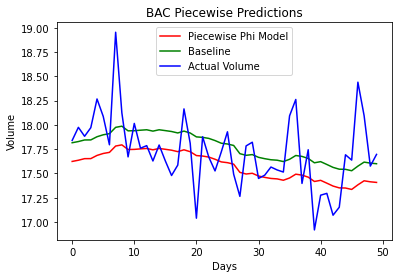

In [222]:
theory = DailyModel(stock)[0].reset_index(drop=True)[0:50]
baseline = DailyModel_base(stock)[0].reset_index(drop=True)[0:50]
practice = stock.loc[stock.DATE > '2020-10-28'].log_vol.reset_index(drop=True)[0:50]
plt.plot(theory, color = 'r', label = 'Piecewise Phi Model')
plt.plot(baseline, color = 'g',label = 'Baseline')
plt.plot(practice, color = 'b', label = 'Actual Volume')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.title('BAC Piecewise Predictions')
plt.legend(loc='upper center')
plt.show
plt.savefig('SUBLINEAR_BAC_2.png', dpi=300)

In [170]:
stock.loc[stock.DATE > '2020-10-28'].log_vol.reset_index(drop=True)

0     17.84
1     17.98
2     17.88
3     17.97
4     18.27
       ... 
292   17.17
293   16.89
294   16.93
295   16.94
296   17.83
Name: log_vol, Length: 297, dtype: float64

In [195]:
theory - baseline

0    -0.13
1    -0.13
2    -0.13
3    -0.13
4    -0.13
5    -0.13
6    -0.13
7    -0.13
8    -0.13
9    -0.13
10   -0.13
11   -0.13
12   -0.13
13   -0.13
14   -0.13
15   -0.13
16   -0.13
17   -0.13
18   -0.13
19   -0.13
20   -0.13
21   -0.13
22   -0.13
23   -0.13
24   -0.13
25   -0.13
26   -0.13
27   -0.13
28   -0.13
29   -0.13
30   -0.13
31   -0.13
32   -0.13
33   -0.13
34   -0.13
35   -0.13
36   -0.13
37   -0.13
38   -0.13
39   -0.13
40   -0.13
41   -0.13
42   -0.13
43   -0.13
44   -0.13
45   -0.13
46   -0.13
47   -0.13
48   -0.13
49   -0.13
Name: log_total_vol_hat, dtype: float64

In [42]:
sp.loc[sp.symbol == 'MRNA']

,DATE,SYM_ROOT,symbol,CPrc,OPrc,total_vol_m,log_vol
147954,2018-12-07,MRNA,MRNA,18.60,22.00,10701654.00,16.19
148582,2018-12-10,MRNA,MRNA,18.80,18.90,4128370.00,15.23
149214,2018-12-11,MRNA,MRNA,18.01,20.55,3302474.00,15.01
149845,2018-12-12,MRNA,MRNA,18.68,18.55,2572439.00,14.76
150477,2018-12-13,MRNA,MRNA,18.76,19.25,1597681.00,14.28
...,...,...,...,...,...,...,...
647198,2021-12-28,MRNA,MRNA,241.44,246.00,8789834.00,15.99
647848,2021-12-29,MRNA,MRNA,247.88,240.00,8902129.00,16.00
648498,2021-12-30,MRNA,MRNA,251.60,243.42,6424599.00,15.68
649147,2021-12-31,MRNA,MRNA,253.98,249.88,6670646.00,15.71


#### To get the sector residual first - Sample: TECH

In [43]:
AAPL = sp.loc[sp.symbol == 'AAPL'].reset_index(drop=True)

(711    18.56
 712    18.59
 713    19.01
 714    18.37
 715    18.54
         ... 
 1003   18.28
 1004   18.25
 1005   17.96
 1006   18.06
 1007   18.03
 Name: log_total_vol_hat, Length: 297, dtype: float64,
 0.5,
 0.5)

In [128]:
BAC = BAC.reset_index(drop=True)
two = BAC.loc[BAC.index > 710].log_vol

0.013514638911644757

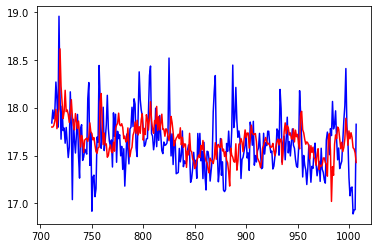

In [145]:
plt.plot(two, color = 'b')
plt.plot(one,color = 'r')
loss_function(two,one)/300

In [13]:
sector_error = np.log(TECH[TECH.index >= '2019-09-24']['total_vol_m']) - DailyModel(TECH)[0]
sector_error

DATE
2019-06-07     NaN
2019-06-10     NaN
2019-06-11     NaN
2019-06-12     NaN
2019-06-13     NaN
              ... 
2019-12-27   -0.29
2019-12-30   -0.19
2019-12-31   -0.30
2020-01-02    0.18
2020-01-03    0.06
Length: 146, dtype: float64

### Getting the stock tickers in the sector and organize it into list